In [97]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = "/Others/CNN/FYP"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
# %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Others/CNN/FYP


In [ ]:
!pip install face-alignment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for face-alignment: filename=face_alignment-1.3.5-py2.py3-none-any.whl size=28241 sha256=cf9ea1d3a637e911424dd9e1599d6cbbac678bc30bc30541bb0a2dc082f26333
  Stored in directory: /root/.cache/pip/wheels/c9/ba/4d/2d368f55e5f929f9472da59e356fbdf1483f885de80a5bc620
Successfully built face-alignment


# Image pre-processing



## 1.   Categorize images

> In this step, we're going to categorize frontal-head-posture images according to emotion labels.





In [ ]:
import os
import shutil

rafd_dir = os.path.join(
    os.getcwd(), "utils/RaFD_dataset"
)
categorized_rafd_dir = os.path.join(
    os.getcwd(), "utils/RaFD_dataset/categorize"
)
if not os.path.exists(categorized_rafd_dir):
  for root, dirs, files in os.walk(rafd_dir):
    for filename in files:
      trim_filename = filename[:(str(filename).find("."))]
      name_list = trim_filename.split("_")
      emotion = name_list[4]
      prefix = name_list[0]
      posture = name_list[5]

      if prefix.lower().startswith("rafd090") or posture.lower() == "frontal":
        emotion_dir = os.path.join(categorized_rafd_dir, emotion)
        if not os.path.exists(emotion_dir):
          os.makedirs(emotion_dir)
            
          original_path = os.path.join(root, filename)
          new_path = os.path.join(emotion_dir, filename)
          
          shutil.copy(original_path, new_path)
  print("Categorized successfully!")
else:
  print("Images are already categorized!")

Images are already categorized!


### *Try with Face-Aligntment!*

*1. Detect the bounding box!*


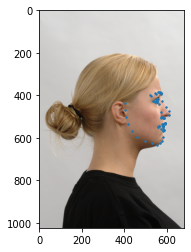

In [ ]:
import face_alignment
import matplotlib.pyplot as plt
from skimage import io

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, face_detector='sfd', device='cpu')
input = io.imread('../FYP/utils/RaFD_dataset/Rafd000_01_Caucasian_female_angry_frontal.jpg')
preds = fa.get_landmarks_from_image(input)
plt.imshow(input)
for detection in preds:
    plt.scatter(detection[:,0], detection[:,1], 2)

*2. Crop image!*

404 385 612 635


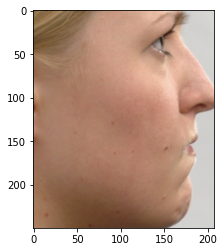

In [ ]:
start_x, start_y, end_x, end_y = 1000, 1000, 0, 0
for detection in preds:
  for item in detection:
    if item[0] < start_x:
      start_x = int(item[0])
    if item[0] > end_x:
      end_x = int(item[0])

    if item[1] < start_y:
      start_y = int(item[1])
    if item[1] > end_y:
      end_y = int(item[1])

print(start_x, start_y, end_x, end_y)
cropped_image = input[start_y: end_y, start_x: end_x]
plt.imshow(cropped_image)

*3. Adjust and crop!*


> This step is to crop the image in square shape.



250 208
383.0 385 633.0 635


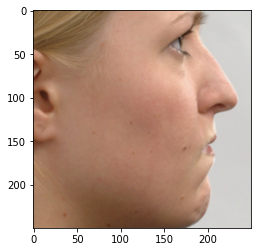

In [ ]:
y_length = int(end_y - start_y)
x_length = int(end_x - start_x)

print(y_length, x_length)

if y_length > x_length:
  start_x = start_x - (y_length - x_length) / 2
  end_x = end_x + (y_length - x_length) / 2

if x_length > y_length:
  start_y = start_y - (x_length - y_length) / 2
  end_y = end_y + (x_length - y_length) / 2

print(start_x, start_y, end_x, end_y)
cropped_image = input[int(start_y): int(end_y), int(start_x): int(end_x)]
plt.imshow(cropped_image)

*4. Resize!*


> Resize the image to 256 * 256.



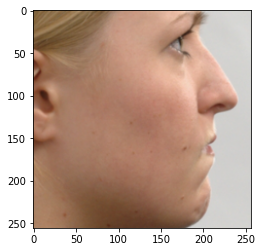

In [ ]:
import cv2
resized_image = cv2.resize(cropped_image, (256, 256)) 
plt.imshow(resized_image)

## 2. Face Alignment


> In this step, we will crop the irrelevant part from the image and make sure our images pixels are 256*256.



In [ ]:
import face_alignment
import matplotlib.pyplot as plt
from skimage import io
import cv2
import os

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, face_detector='sfd', device='cuda')

# categorized images folder
categorized_rafd_dir = os.path.join(
    os.getcwd(), "utils/RaFD_dataset/categorize"
)

# cropped images folder
processed_rafd_dir = os.path.join(
    os.getcwd(), "utils/RaFD_dataset/processed"
)

# start cropping images if the cropped images folder does not exist
if not os.path.exists(processed_rafd_dir):
  for dir in os.listdir(categorized_rafd_dir):
    emotion_dir = os.path.join(categorized_rafd_dir, dir)
    processed_dir = emotion_dir.replace("categorize", "processed")
    os.makedirs(processed_dir)

    for filename in os.listdir(emotion_dir):
      input = io.imread(os.path.join(emotion_dir, filename))
      preds = fa.get_landmarks_from_image(input)
      
      start_x, start_y, end_x, end_y = 1000, 1000, 0, 0
      for detection in preds:
        for item in detection:
          if item[0] < start_x:
            start_x = int(item[0])
          if item[0] > end_x:
            end_x = int(item[0])

          if item[1] < start_y:
            start_y = int(item[1])
          if item[1] > end_y:
            end_y = int(item[1])
        
        y_length = int(end_y - start_y)
        x_length = int(end_x - start_x)

        if y_length > x_length:
          start_x = start_x - (y_length - x_length) / 2
          end_x = end_x + (y_length - x_length) / 2

        if x_length > y_length:
          start_y = start_y - (x_length - y_length) / 2
          end_y = end_y + (x_length - y_length) / 2

        start_x = start_x if start_x > 0 else 0
        start_y = start_y if start_y > 0 else 0

        cropped_image = input[int(start_y): int(end_y), int(start_x): int(end_x)]
        resized_image = cv2.resize(cropped_image, (256, 256)) 

        cv2.imwrite(os.path.join(processed_dir, filename), cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))

  print("Processed successfully!")
else:
  print("Images already processed!")


Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


  0%|          | 0.00/85.7M [00:00<?, ?B/s]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip


  0%|          | 0.00/91.9M [00:00<?, ?B/s]

Processed successfully!


# PyTorch - Three-Layers Convolutional Neural Network

### 1. Import libraries

In [65]:
import itertools
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as transforms

from torchsummary import summary

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class_names = ['angry', 'contemptuous', 'disgusted', 'fearful', 'happy', 'neural', 'sad', 'surprise']

# util function to plot matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()

### 2. Setup hyper parameters

In [66]:
# Hyper parameters
num_epochs = 50
num_classes = 8
batch_size = 32
learning_rate = 0.001
decay_rate = 0.1
train_data_ratio = 0.9

### 3. Transform image to tensor data, split and load train / test data 

In [67]:
processed_rafd_dir = os.path.join(
    os.getcwd(), "utils/RaFD_dataset/processed"
)

# normalize = transforms.Normalize(
#     mean=[0.485, 0.456, 0.406],
#     std=[0.229, 0.224, 0.225]
#     )

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # normalize,
])

dataset = dset.ImageFolder(
    root=processed_rafd_dir,
    transform=train_transform,
    )

# Split train / test data
total_data_sum = (len(dataset))
train_data_sum = int(train_data_ratio * len(dataset))
test_data_sum = total_data_sum - train_data_sum
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_data_sum, test_data_sum])

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### 4. Initialize three-layer convolutional network model

In [68]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ThreeLayerConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(32*32*64, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ThreeLayerConvNet(num_classes).to(device)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]           1,216
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
         MaxPool2d-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]          12,832
       BatchNorm2d-6         [-1, 32, 128, 128]              64
              ReLU-7         [-1, 32, 128, 128]               0
         MaxPool2d-8           [-1, 32, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          51,264
      BatchNorm2d-10           [-1, 64, 64, 64]             128
             ReLU-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 32, 32]               0
           Linear-13                    [-1, 8]         524,296
Total params: 589,832
Trainable params:

### 5. Train and evaluate

In [69]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Logger information
losses = []
accuracies = []

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
  running_loss = 0.0
  running_correct = 0.0
  
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # calculate the loss/acc later
    _, predicted = torch.max(outputs.data, 1)
    running_loss += loss.item()
    running_correct += (labels==predicted).sum().item()
    
    if (i+1) % 10 == 0:
      print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
      .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

  epoch_loss = running_loss/len(train_loader)
  epoch_acc = 100/32*running_correct/len(train_loader)
  
  losses.append(epoch_loss)
  accuracies.append(epoch_acc)

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # calculate confusion matrix
        if i == 0:
          all_targets = labels
          all_predicted = predicted
        else:
          all_targets = torch.cat((all_targets, labels), 0)
          all_predicted = torch.cat((all_predicted, predicted), 0)

    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

torch.save(model.state_dict(), 'trained_three_layer_model.pth')

Epoch [1/50], Step [10/106], Loss: 18.9402
Epoch [1/50], Step [20/106], Loss: 12.6113
Epoch [1/50], Step [30/106], Loss: 5.1267
Epoch [1/50], Step [40/106], Loss: 3.1508
Epoch [1/50], Step [50/106], Loss: 1.8897
Epoch [1/50], Step [60/106], Loss: 2.7895
Epoch [1/50], Step [70/106], Loss: 2.9269
Epoch [1/50], Step [80/106], Loss: 2.6423
Epoch [1/50], Step [90/106], Loss: 2.7161
Epoch [1/50], Step [100/106], Loss: 2.1586
Epoch [2/50], Step [10/106], Loss: 2.2480
Epoch [2/50], Step [20/106], Loss: 1.0642
Epoch [2/50], Step [30/106], Loss: 0.9568
Epoch [2/50], Step [40/106], Loss: 1.6830
Epoch [2/50], Step [50/106], Loss: 1.7028
Epoch [2/50], Step [60/106], Loss: 2.7115
Epoch [2/50], Step [70/106], Loss: 2.0711
Epoch [2/50], Step [80/106], Loss: 1.4650
Epoch [2/50], Step [90/106], Loss: 2.6664
Epoch [2/50], Step [100/106], Loss: 1.5216
Epoch [3/50], Step [10/106], Loss: 1.0857
Epoch [3/50], Step [20/106], Loss: 0.8933
Epoch [3/50], Step [30/106], Loss: 0.9415
Epoch [3/50], Step [40/106], L

### 6. Visualize results



> Training results - losses and accuracies



Text(0.5, 1.0, 'Training acc')

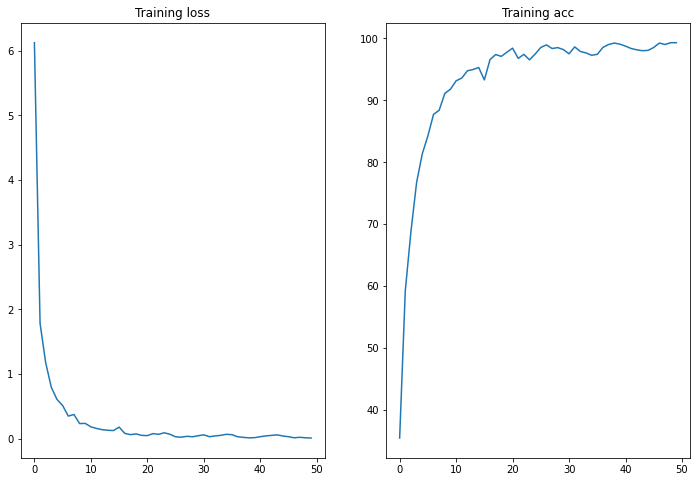

In [70]:
# plot the stats

f, axarr = plt.subplots(1, 2, figsize = (12, 8))
axarr[0].plot(losses)
axarr[0].set_title("Training loss")
axarr[1].plot(accuracies)
axarr[1].set_title("Training acc")



> Testing result - confusion matrix and accuracies



Normalized confusion matrix
[[0.76 0.08 0.02 0.   0.02 0.06 0.06 0.  ]
 [0.03 0.87 0.   0.   0.   0.08 0.03 0.  ]
 [0.02 0.   0.98 0.   0.   0.   0.   0.  ]
 [0.   0.04 0.   0.87 0.   0.07 0.   0.02]
 [0.   0.02 0.   0.   0.95 0.   0.02 0.  ]
 [0.   0.23 0.   0.03 0.   0.68 0.07 0.  ]
 [0.05 0.07 0.   0.04 0.   0.11 0.72 0.02]
 [0.   0.   0.   0.1  0.   0.02 0.   0.88]]


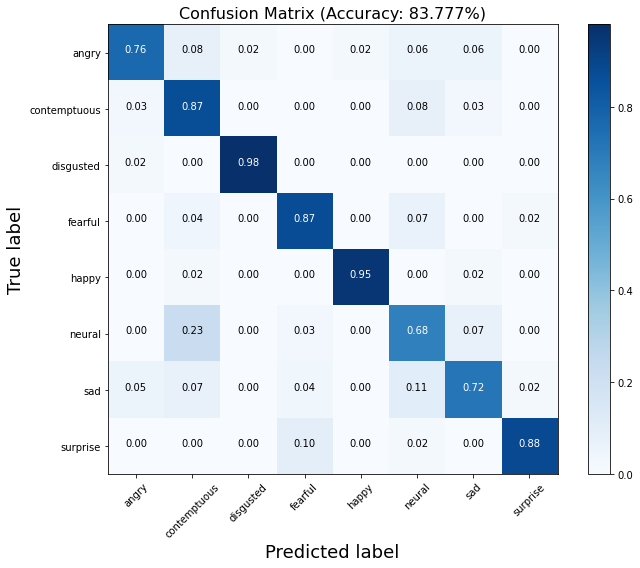

In [71]:
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.data.cpu().numpy())
np.set_printoptions(precision=2)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, 
                      classes=class_names, 
                      normalize=True,
                      title='Confusion Matrix (Accuracy: %0.3f%%)' %(100 * correct / total))

# PyTorch - VGG Training Model

### 1. Import libraries

In [76]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import DataLoader
from torch.utils.data import sampler

from torchvision import models
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torchsummary import summary

import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 2. Setup hyper parameters

In [77]:
# Hyper parameters
num_epochs = 50
num_classes = 8
batch_size = 32
learning_rate = 0.001
train_data_ratio = 0.9

### 3. Transform image to tensor data, split and load train / test data

In [78]:
processed_rafd_dir = os.path.join(
    os.getcwd(), "utils/RaFD_dataset/processed"
)

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = dset.ImageFolder(
    root=processed_rafd_dir,
    transform=train_transform,
    )

# Split train / test data
total_data_sum = (len(dataset))
train_data_sum = int(train_data_ratio * len(dataset))
test_data_sum = total_data_sum - train_data_sum
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_data_sum, test_data_sum])

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### 4. Initialize Visual Geometry Group (VGG) Network

In [79]:
model_vgg19 = models.vgg19_bn(num_classes=num_classes).to(device)
summary(model_vgg19, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

### 5. Train and evaluate

In [80]:
model_vgg19.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg19.parameters(), lr=learning_rate)

# Logger information
losses = []
accuracies = []

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
  running_loss = 0.0
  running_correct = 0.0
  
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = model_vgg19(images)
    loss = criterion(outputs, labels)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # calculate the loss/acc later
    _, predicted = torch.max(outputs.data, 1)
    running_loss += loss.item()
    running_correct += (labels==predicted).sum().item()
    
    if (i+1) % 10 == 0:
      print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
      .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

  epoch_loss = running_loss/len(train_loader)
  epoch_acc = 100/32*running_correct/len(train_loader)

  losses.append(epoch_loss)
  accuracies.append(epoch_acc)

# Test the model
model_vgg19.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_vgg19(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # calculate for confusion matrix
        if i == 0:
          all_targets = labels
          all_predicted = predicted
        else:
          all_targets = torch.cat((all_targets, labels), 0)
          all_predicted = torch.cat((all_predicted, predicted), 0)

    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

torch.save(model_vgg19.state_dict(), 'trained_vgg_model.pth')

Epoch [1/50], Step [10/106], Loss: 2.3358
Epoch [1/50], Step [20/106], Loss: 2.2000
Epoch [1/50], Step [30/106], Loss: 2.0475
Epoch [1/50], Step [40/106], Loss: 2.1753
Epoch [1/50], Step [50/106], Loss: 2.0414
Epoch [1/50], Step [60/106], Loss: 2.1604
Epoch [1/50], Step [70/106], Loss: 2.1296
Epoch [1/50], Step [80/106], Loss: 2.1046
Epoch [1/50], Step [90/106], Loss: 2.0960
Epoch [1/50], Step [100/106], Loss: 2.1099
Epoch [2/50], Step [10/106], Loss: 2.1238
Epoch [2/50], Step [20/106], Loss: 2.2150
Epoch [2/50], Step [30/106], Loss: 1.9992
Epoch [2/50], Step [40/106], Loss: 1.9116
Epoch [2/50], Step [50/106], Loss: 1.8792
Epoch [2/50], Step [60/106], Loss: 1.8239
Epoch [2/50], Step [70/106], Loss: 1.9323
Epoch [2/50], Step [80/106], Loss: 2.1860
Epoch [2/50], Step [90/106], Loss: 1.8693
Epoch [2/50], Step [100/106], Loss: 1.9258
Epoch [3/50], Step [10/106], Loss: 1.7262
Epoch [3/50], Step [20/106], Loss: 1.8871
Epoch [3/50], Step [30/106], Loss: 1.6664
Epoch [3/50], Step [40/106], Los

### 6. Visualize results



> Training results - losses and accuracies



Text(0.5, 1.0, 'Training acc')

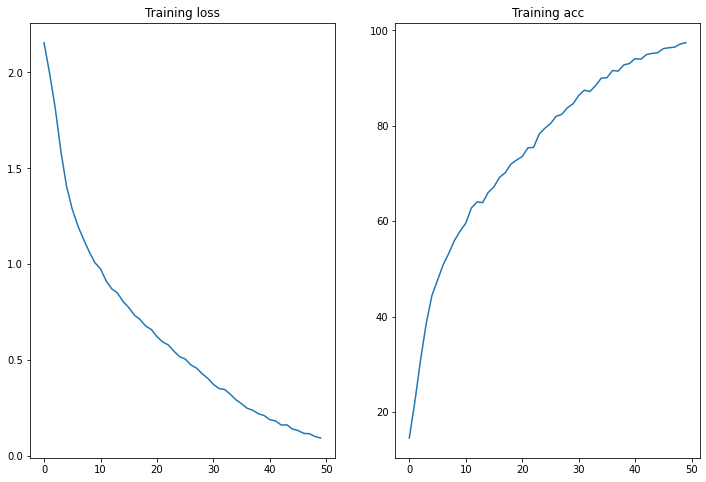

In [81]:
# plot the stats

f, axarr = plt.subplots(1, 2, figsize = (12, 8))
axarr[0].plot(losses)
axarr[0].set_title("Training loss")
axarr[1].plot(accuracies)
axarr[1].set_title("Training acc")



> Testing result - confusion matrix and accuracies



Normalized confusion matrix
[[0.95 0.05 0.   0.   0.   0.   0.   0.  ]
 [0.21 0.58 0.   0.   0.   0.02 0.19 0.  ]
 [0.05 0.   0.93 0.   0.   0.   0.   0.02]
 [0.   0.02 0.   0.74 0.   0.13 0.04 0.06]
 [0.   0.   0.07 0.   0.93 0.   0.   0.  ]
 [0.18 0.19 0.04 0.   0.   0.54 0.05 0.  ]
 [0.25 0.02 0.   0.   0.   0.02 0.71 0.  ]
 [0.   0.   0.   0.05 0.   0.   0.   0.95]]


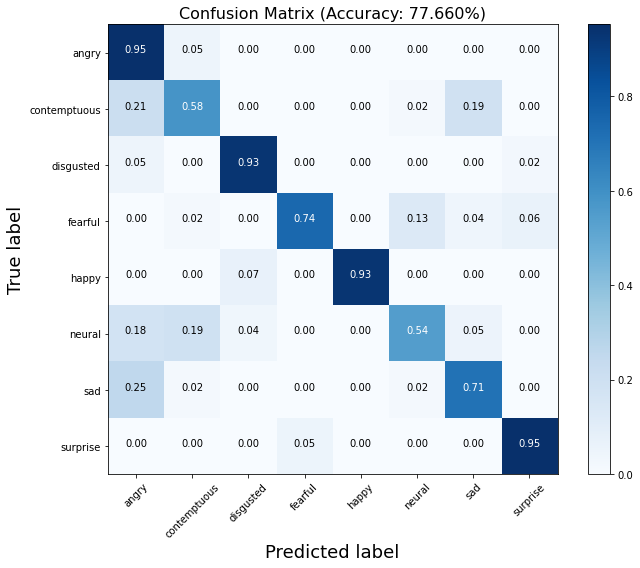

In [82]:
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.data.cpu().numpy())
np.set_printoptions(precision=2)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, 
                      classes=class_names, 
                      normalize=True,
                      title='Confusion Matrix (Accuracy: %0.3f%%)' %(100 * correct / total))

# Forward an image and predict

In [135]:
from PIL import Image
import numpy as np
from skimage import transform

# set up the test image name and label 
IMAGE_NAME = 'Rafd000_02_Caucasian_female_neutral_frontal.jpg'
IMAGE_LABEL = 'neutral'

# get the path for test image
image_path = os.path.join(os.getcwd(), "utils/RaFD_dataset/processed", IMAGE_LABEL, IMAGE_NAME)

# load the test image to tensor object
loader = transforms.Compose([transforms.ToTensor()])
image = Image.open(image_path)
image = loader(image).float()
image_numpy = np.expand_dims(image.cpu().numpy(), axis=0)
image = torch.Tensor(image_numpy)
image = image.to(device)

# predict for the test image
with torch.no_grad():
  model_vgg19.eval()
  output = model_vgg19(image)
  index = output.data.cpu().numpy().argmax()

  print(class_names[index])

neural
